# Robust Successive Binarizations (RSB) for Change Detection in Hyperspectral Images

In [1]:
#Necessary libraries to be imported:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
from os.path import dirname, join as pjoin
from scipy.io import loadmat
from sklearn.metrics import confusion_matrix
import cv2
from sklearn.naive_bayes import GaussianNB
from scipy import stats

LOAD the DATASETS $_____________________________________________________________________________$

The followin dataset have been downloaded from here:

- Hermiston: https://gitlab.citius.usc.es/hiperespectral/ChangeDetectionDataset/-/tree/master/Hermiston 

- USA: https://rslab.ut.ac.ir/documents/81960329/82034892/Hyperspectral_Change_Datasets.zip

- River: http://crabwq.github.io

Plase, replace the following ``filepath``, ``filepathU``, ``filepathR`` string with your own.

In [2]:
filepath = 'C:/Users/antonella/Downloads/ChangeDetectionDataset-master-Hermiston/ChangeDetectionDataset-master-Hermiston/Hermiston' 
her1 = pjoin(filepath,'hermiston2004.mat')
her2 = pjoin(filepath,'hermiston2007.mat')
gt = pjoin(filepath,'rdChangesHermiston_5classes.mat')

In [3]:
filepathU = 'C:/Users/antonella/Downloads/Hyperspectral_Change_Datasets'
usa1 = pjoin(filepathU,'USA1.mat')
usa2 = pjoin(filepathU,'USA2.mat')
gtU = pjoin(filepathU,'USA_gt.mat')

In [4]:
filepathR = 'C:/Users/antonella/Downloads/GETNET/zuixin'
river1 = pjoin(filepathR,'river_before.mat')
river2 = pjoin(filepathR,'river_after.mat')
gtR = pjoin(filepathR,'groundtruth.mat')

In [5]:
her1 = loadmat(her1) # Dictionary
her1 = her1['HypeRvieW']
her1 = her1.astype(float)
her2 = loadmat(her2) # Dictionary
her2 = her2['HypeRvieW']
her2 = her2.astype(float)

usa1 = loadmat(usa1)
usa1 = usa1['USA1']
usa1 = usa1.astype(float)
usa2 = loadmat(usa2) # Dictionary
usa2 = usa2['USA2']
usa2 = usa2.astype(float)

river1 = loadmat(river1)
river1 = river1['river_before']
river1 = river1.astype(float)
river2 = loadmat(river2) # Dictionary
river2 = river2['river_after']
river2 = river2.astype(float)

In [6]:
gt = loadmat(gt)
gt = gt['gt5clasesHermiston']
gt = gt.astype(float)

gtU = loadmat(gtU)
gtU = gtU['USA_gt']
gtU = gtU.astype(float)

gtR = loadmat(gtR)
gtR = gtR['lakelabel_v1']
gtR = gtR.astype(float)

In [7]:
# Hermiston GT is given for multi-class, hence in order to produce only the binary map of 
# changed/not-changed pixels, we need to set to 1 all the changed pixels

n2 = np.where(gt.ravel()==2)
n3 = np.where(gt.ravel()==3)
n4 = np.where(gt.ravel()==4)
n5 = np.where(gt.ravel()==5)

new_gt = gt.ravel()
######## &&&& Only for  Hermiston
new_gt[n2] = 1
new_gt[n3] = 1
new_gt[n4] = 1
new_gt[n5] = 1

In [8]:
[m1,n1,k1] = her1.shape
print('Hermiston dataset size ', m1,n1,k1)

H1 = np.reshape(her1,[m1*n1,k1])
print('Hermiston vectorized ', H1.shape)

[m2,n2,k2] = her2.shape

H2 = np.reshape(her2,[m2*n2,k2])

[mu1,nu1,ku1] = usa1.shape
print('USA dataset size  ', mu1,nu1,ku1)

U1 = np.reshape(usa1,[mu1*nu1,ku1])
print('USA vectorized ', U1.shape)

[mu2,nu2,ku2] = usa2.shape

U2 = np.reshape(usa2,[mu2*nu2,ku2])

[mr1,nr1,kr1] = river1.shape
print('River dataset size  ', mr1,nr1,kr1)

R1 = np.reshape(river1,[mr1*nr1,kr1])
print('River vectorized ', R1.shape)

[mr2,nr2,kr2] = river2.shape

R2 = np.reshape(river2,[mr2*nr2,kr2])

Hermiston dataset size  390 200 242
Hermiston vectorized  (78000, 242)
USA dataset size   307 241 154
USA vectorized  (73987, 154)
River dataset size   463 241 198
River vectorized  (111583, 198)


# Error Function Definitions

The fucntions: SAM-MEAN, newSSCC (i.e., SMSADM) and SAM_g_ZID have been introduced here:

-Falini, A., Tamborrino, C., Castellano, G., Mazzia, F., Mininni, R. M., Appice, A., & Malerba, D. (2020, July). Novel reconstruction errors for saliency detection in hyperspectral images. In International Conference on Machine Learning, Optimization, and Data Science (pp. 113-124). Springer, Cham.

In [9]:
def SAM(x,y):
    ''' 
    INPUT:
    x and y are two mono-dimensional arrais.
    OUTPUT:
    scalar value
    '''
    
    norm2_x = np.linalg.norm(x)
    norm2_y = np.linalg.norm(y)
    return np.arccos(np.dot(x,y)/(norm2_x*norm2_y))


def SAM_MEAN(A, B, windowSize=2):
    ''' 
    INPUT:
    A and B are 3-mode tensors with size rows x col x feature
    
    OUTPUT:
    a matrix of size rows x col
    '''
    
    
    row, col, feature= A.shape
    C= np.zeros([row, col])       
    windSizeMatrix=np.zeros((row, col))
   
    for i in range(-windowSize, +windowSize+1):
        for j in range(-windowSize, +windowSize+1):
            rowS=max(0,i)
            rowE=min(row,row+i)
            colS=max(0,j)
            colE=min(col,col+j)
            windSizeMatrix[row-rowE:row-rowS, col-colE:col-colS]+=1
            den1= np.sqrt(np.sum(np.multiply(A[rowS:rowE, colS:colE], A[rowS:rowE, colS:colE]), axis=2))
            den1[den1 < 1e-5]=1e-5
                
            den2= np.sqrt(np.sum(np.multiply(B[rowS:rowE, colS:colE], B[rowS:rowE, colS:colE]), axis=2))                
            den2[den2 < 1e-5]=1e-5
            num=np.sum(np.multiply(A[rowS:rowE, colS:colE],B[rowS:rowE, colS:colE]),axis=2)                
            ndiv = np.divide(num, np.multiply(den1,den2))
            ndiv[ndiv > 1] = 1.
            ndiv[ndiv <-1] = -1.
            count=np.arccos(ndiv)
                         
            C[row-rowE:row-rowS, col-colE:col-colS]+=count
                  
        
    C=np.divide(C, windSizeMatrix).reshape(row,col)
    
    return C

In [10]:
def newSSCC(A, B, windowSize=2):
    ''' 
    INPUT:
    A and B are 3-mode tensors with size rows x col x feature
    
    OUTPUT:
    a matrix of size rows x col
    '''
    row, col, feature= A.shape

    nPixel=row*col 
    sumA = A.sum(axis=2)
    sumB = B.sum(axis=2)
    
    BwindowMean=np.zeros(sumB.shape)
    numT=np.zeros(sumA.shape)
    den2T=np.zeros(sumA.shape)
    denT=np.zeros(sumA.shape)
    
    AwindowMean=np.zeros(sumA.shape)        
    windSizeMatrix=np.zeros(sumA.shape)   
    den1T=np.zeros(sumA.shape)
       
    for i in range(-windowSize, +windowSize+1):
        for j in range(-windowSize, +windowSize+1):
                rowS=max(0,i)
                rowE=min(row,row+i)
                colS=max(0,j)
                colE=min(col,col+j)
                AwindowMean[row-rowE:row-rowS, col-colE:col-colS]+=sumA[rowS:rowE, colS:colE]
                
                BwindowMean[row-rowE:row-rowS, col-colE:col-colS]+=sumB[rowS:rowE, colS:colE]
                windSizeMatrix[row-rowE:row-rowS, col-colE:col-colS]+=1
        #windSizeMatrix=np.multiply(windSizeMatrix,windSizeMatrix)
        AwindowMean=AwindowMean/(feature)
        #print('\n max AwindowMean ', np.max(AwindowMean))
        BwindowMean=BwindowMean/(feature)
        #print('\n max BwindowMean ', np.max(BwindowMean))
        #print('\n max windSizeMatrix ', np.max(windSizeMatrix))
        BwindowMean=np.divide(BwindowMean, windSizeMatrix)
        AwindowMean=np.divide(AwindowMean, windSizeMatrix)
        #print('\n First division ')
        
        for i in range(-windowSize, +windowSize+1):
            for j in range(-windowSize, +windowSize+1):
                rowS=max(0,i)
                rowE=min(row,row+i)
                colS=max(0,j)
                colE=min(col,col+j)
                Asubtract=np.zeros(A.shape)
                Bsubtract=np.zeros(A.shape)
                

                Asubtract[rowS:rowE, colS:colE]=A[rowS:rowE, colS:colE]-AwindowMean[row-rowE:row-rowS, col-colE:col-colS].reshape(row-rowS-(row-rowE),col-colS-(col-colE),1)
                Bsubtract[rowS:rowE, colS:colE]=B[rowS:rowE, colS:colE]-BwindowMean[row-rowE:row-rowS, col-colE:col-colS].reshape(row-rowS-(row-rowE),col-colS-(col-colE),1)
                
                den1T[row-rowE:row-rowS, col-colE:col-colS]+=np.einsum('ijn,ijn->ij', Asubtract[rowS:rowE, colS:colE], Asubtract[rowS:rowE, colS:colE])
                
                numT[row-rowE:row-rowS, col-colE:col-colS]+=np.einsum('ijn,ijn->ij', Asubtract[rowS:rowE, colS:colE], Bsubtract[rowS:rowE, colS:colE])
                den2T[row-rowE:row-rowS, col-colE:col-colS]+=np.einsum('ijn,ijn->ij', Bsubtract[rowS:rowE, colS:colE], Bsubtract[rowS:rowE, colS:colE])
        
        denT=np.multiply(np.sqrt(den1T),np.sqrt(den2T))
        denT[denT< 1e-5]=1e-5
        #print('\n max den1T ', np.max(den1T))
        #print('\n max den2T ', np.max(den2T))
        C=1-np.divide(numT,denT).reshape(row, col)
        #print('\n second division ')
        return C
   

In [11]:
def nor01(matrix):
    mi=(matrix.min())
    ma=(matrix).max()
    return (matrix-mi)/(ma-mi)

def Scale(Matrix):
    minMat = np.min(Matrix)
    MaxMat = np.max(Matrix)
    return 1/(MaxMat-minMat+1e-8)*(Matrix-minMat)

def SAM_ZID(A,B):
    ''' 
    INPUT:
    A and B are 3-mode tensors with size rows x col x feature
    
    OUTPUT:
    a matrix of size rows x col
    '''
    row, column, feature= A.shape
    nPixel=row*column
    sam = np.zeros([1,nPixel])
    Ac = A.reshape(nPixel,feature)
    Bc = B.reshape(nPixel,feature)
    for i in range(nPixel):
        sam[0,i] = SAM(Ac[i,:], Bc[i,:])
    diffe = abs(Ac-Bc)
    temp = np.zeros([nPixel, feature])
    for k in range(nPixel):
        temp[k,:] = ((diffe[k,:]-np.mean(diffe[k,:]))/np.std(diffe[k,:]))**2
    zid = np.sum(temp, axis=1)
    sin_angle = nor01( np.sin( sam ))
    zidj = nor01(zid)
    sam_zid= np.prod([[sin_angle[0,:],zidj]], axis=1)
    
    return sam_zid

def ZID_g_mod(A,B):
    ''' 
    INPUT:
    A and B are 3-mode tensors with size rows x col x feature
    
    OUTPUT:
    a matrix of size rows x col
    '''
        
    row, column, feature= A.shape    
    nPixel=row*column
    A= (A.reshape(nPixel,feature))
    B = B.reshape(nPixel,feature)
    mu_g0=np.zeros([nPixel,1] )
    sigma_g0 = np.zeros([nPixel,1] )
    muB=np.zeros([nPixel,1] )
    sigmaB = np.zeros([nPixel,1] )
    muA=np.zeros([nPixel,1] )
    sigmaA = np.zeros([nPixel,1] )
    C0 =np.copy(abs(A-B)) # modified
 
    eta = 1e-10        
    mu_g0[:,0] = ( (np.sum(np.log(( C0+eta)),axis=1)/A.shape[1]) )       

    sigma_g0[:,0] = ( np.sum((( C0+eta-mu_g0)**2), axis=1)/(A.shape[1]) )        
    sigma_g0[sigma_g0 < 1e-10]=1e-5
  
    zid_g = np.sum( (C0-(np.exp(mu_g0)))**2/( ((sigma_g0)) ),axis=1)
    return zid_g

def SAM_g_ZID(A,B):
    ''' 
    INPUT:
    A and B are 3-mode tensors with size rows x col x feature
    
    OUTPUT:
    a matrix of size rows x col
    '''
    row, column, feature= A.shape
    nPixel=row*column
    sam = np.zeros([1,nPixel])
    Ac = A.reshape(nPixel,feature)
    Bc = B.reshape(nPixel,feature)
    for i in range(nPixel):
        sam[0,i] = SAM(Ac[i,:], Bc[i,:])

    zid =(ZID_g_mod(A,B))
    sin_angle = nor01( np.tan( sam ))
    zidj = nor01(zid)
    sam_zid= np.prod([[sin_angle[0,:],zidj]],axis=1)
    
    return sam_zid


def OA_K(cnf):
    index = np.nonzero(cnf)
    TN, FP, FN, TP=cnf[index]   
    OA = (TP+TN)/(TP+TN+FP+FN)  
    p = ((TP + FP)*(TP+FN)+(TN+FN)*(TN+FP))/(TP + TN + FP + FN)**2
    Kappa = (OA-p)/(1-p)   
    return OA,Kappa

def Binarize1(M):
    ''' 
    INPUT:
    M is a matrix, i.e., a bidimensional array
    
    OUTPUT:
    a flattened matrix
    '''
    Temp = np.copy(M)
    Temp2 = np.copy(Temp)
    Temp3 = np.copy(Temp)
    Temp4 = np.copy(Temp)
    Temp5 = np.copy(Temp)
    Temp6 = np.copy(Temp) 
    
    Temp2[Temp>=0.2]=1
    Temp2[Temp<0.2]=0

    Temp3[Temp>=0.3]=1
    Temp3[Temp<0.3]=0

    Temp4[Temp>=0.4]=1
    Temp4[Temp<0.4]=0

    Temp5[Temp>=0.5]=1
    Temp5[Temp<0.5]=0

    Temp6[Temp>=0.6]=1
    Temp6[Temp<0.6]=0
    
    MediaM = (Temp2+Temp3+Temp4+Temp5+ Temp6)/2.0
    
    return MediaM

#  Euclidean distance 

In [12]:
diff_matH = H1-H2
EuH = np.zeros([1,m1*n1])
for i in range(m1*n1):
    EuH[0,i] = np.linalg.norm(diff_matH[i,:])
    

diff_matU = U1-U2
EuU = np.zeros([1,mu1*nu1])
for i in range(mu1*nu1):
    EuU[0,i] = np.linalg.norm(diff_matU[i,:])
    

diff_matR = R1-R2
EuR = np.zeros([1,mr1*nr1])
for i in range(mr1*nr1):
    EuR[0,i] = np.linalg.norm(diff_matR[i,:])


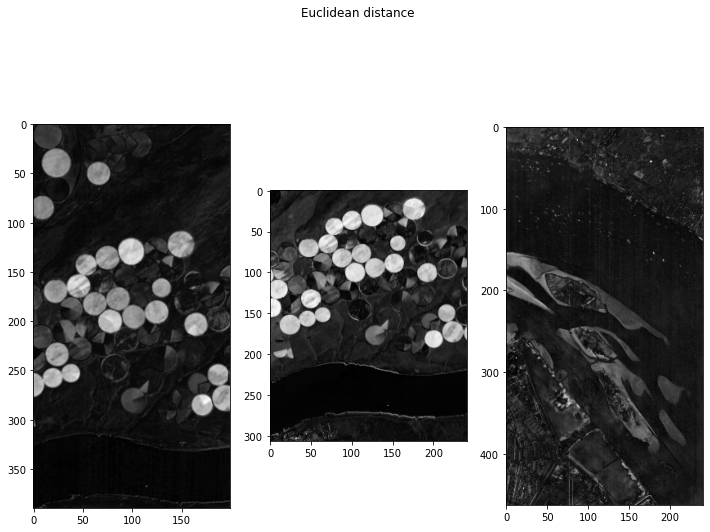

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,9))
fig.suptitle('Euclidean distance')
ax1.imshow(EuH.reshape(m1,n1),cmap = plt.cm.gray)
ax2.imshow(EuU.reshape(mu1,nu1),cmap = plt.cm.gray)
ax3.imshow(EuR.reshape(mr1,nr1),cmap = plt.cm.gray)


We apply binarization:
- We scale the matrix values between 0 and 1
- We apply several thresholds

In [15]:
EuH = Scale(EuH)

EuU = Scale(EuU)

EuR = Scale(EuR)

In [16]:
MediaEuH = Binarize1(EuH)
MediaEuH[MediaEuH>=1.0]=1.0
MediaEuH[MediaEuH<1.0]=0.0
MediaEuH = MediaEuH.astype(int)

MediaEuU = Binarize1(EuU)
MediaEuU[MediaEuU>=1.0]=1.0
MediaEuU[MediaEuU<1.0]=0.0
MediaEuU = MediaEuU.astype(int)

MediaEuR = Binarize1(EuR)
MediaEuR[MediaEuR>=1.0]=1.0
MediaEuR[MediaEuR<1.0]=0.0
MediaEuR = MediaEuR.astype(int)

# SAMZID

In [17]:
Hssz = SAM_ZID(H1.reshape(m1,n1,k1),H2.reshape(m2,n2,k2))

Ussz = SAM_ZID(U1.reshape(mu1,nu1,ku1),U2.reshape(mu2,nu2,ku2))

Rssz = SAM_ZID(R1.reshape(mr1,nr1,kr1),R2.reshape(mr2,nr2,kr2))

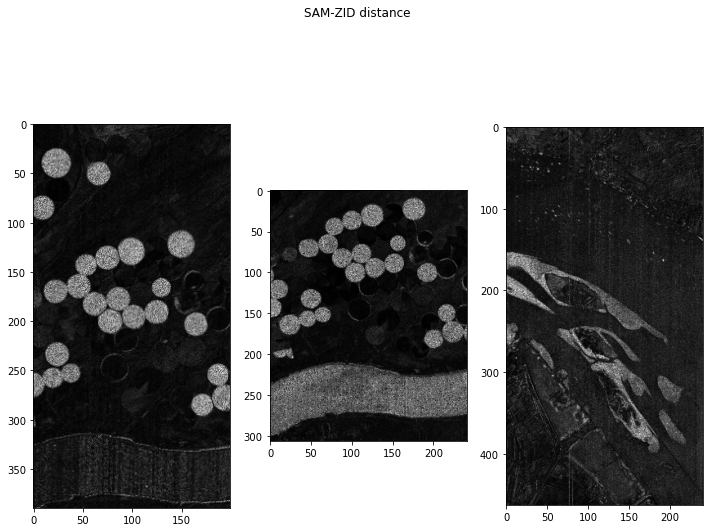

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(12,9))
fig.suptitle('SAM-ZID distance')
ax1.imshow(Hssz.reshape(m1,n1),cmap = plt.cm.gray)
ax2.imshow(Ussz.reshape(mu1,nu1), cmap = plt.cm.gray)
ax3.imshow(Rssz.reshape(mr1,nr1), cmap = plt.cm.gray)

In [19]:
Hssz = Scale(Hssz)

Ussz = Scale(Ussz)

Rssz = Scale(Rssz)

In [20]:
MediaHssz = Binarize1(Hssz)
MediaHssz[MediaHssz>=1.0]=1.0
MediaHssz[MediaHssz<1.0]=0.0
MediaHssz = MediaHssz.astype(int)


MediaUssz =  Binarize1(Ussz)
MediaUssz[MediaUssz>=1.0]=1.0
MediaUssz[MediaUssz<1.0]=0.0
MediaUssz = MediaUssz.astype(int)


MediaRssz =  Binarize1(Rssz)
MediaRssz[MediaRssz>=1.0]=1.0
MediaRssz[MediaRssz<1.0]=0.0
MediaRssz= MediaRssz.astype(int)

# SAM-MEAN

In [21]:
HsM = SAM_MEAN(H1.reshape(m1,n1,k1), H2.reshape(m2,n2,k2))

UsM = SAM_MEAN(U1.reshape(mu1,nu1,ku1), U2.reshape(mu2,nu2,ku2))

RsM = SAM_MEAN(R1.reshape(mr1,nr1,kr1), R2.reshape(mr2,nr2,kr2))

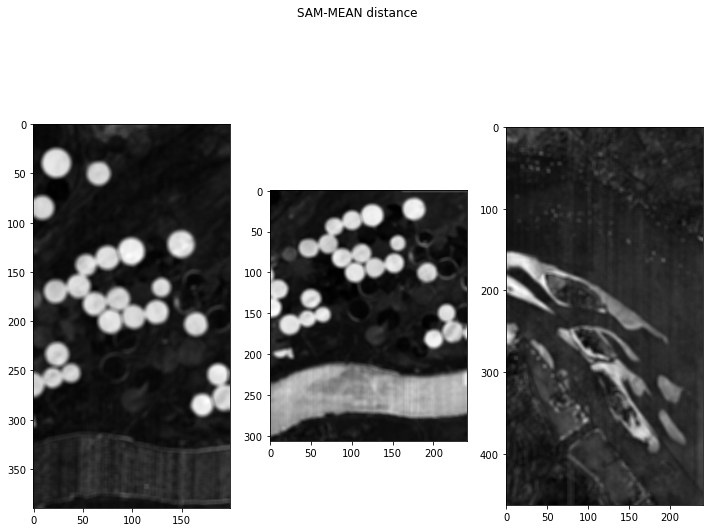

In [23]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(12,9))
fig.suptitle('SAM-MEAN distance')
ax1.imshow(HsM,cmap = plt.cm.gray)
ax2.imshow(UsM, cmap = plt.cm.gray)
ax3.imshow(RsM, cmap = plt.cm.gray)

In [24]:
HsM = Scale(HsM)

UsM = Scale(UsM)

RsM = Scale(RsM)

In [25]:
MediaHsM =  Binarize1(HsM)
MediaHsM[MediaHsM>=1.0]=1.0
MediaHsM[MediaHsM<1.0]=0.0
MediaHsM = MediaHsM.astype(int)


MediaUsM =  Binarize1(UsM)
MediaUsM[MediaUsM>=1.0]=1.0
MediaUsM[MediaUsM<1.0]=0.0
MediaUsM = MediaUsM.astype(int)


MediaRsM =  Binarize1(RsM)
MediaRsM[MediaRsM>=1.0]=1.0
MediaRsM[MediaRsM<1.0]=0.0
MediaRsM = MediaRsM.astype(int)

In [26]:
'''To uncomment only if chunks of codes are run not in the prescribed order, as  dimensions might be different'''

#[m1,n1,k1] = her1.shape

#H1 = np.reshape(her1,[m1*n1,k1])

#[m2,n2,k2] = her2.shape

#H2 = np.reshape(her2,[m2*n2,k2])

'To uncomment only if chunks of codes are run not in the prescribed order, as  dimensions might be different'

# SMSADM

In [27]:
Hsc = newSSCC(H1.reshape(m1,n1,k1), H2.reshape(m2,n2,k2))

Usc = newSSCC(U1.reshape(mu1,nu1,ku1), U2.reshape(mu2,nu2,ku2))

Rsc = newSSCC(R1.reshape(mr1,nr1,kr1), R2.reshape(mr2,nr2,kr2))

C:\Users\antonella\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
C:\Users\antonella\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


In [28]:
# The images are not preprocessed, SMSADM might produces some sporious "0/0"
Hsc[np.isnan(Hsc)]=0

Usc[np.isnan(Usc)]=0

Rsc[np.isnan(Rsc)]=0


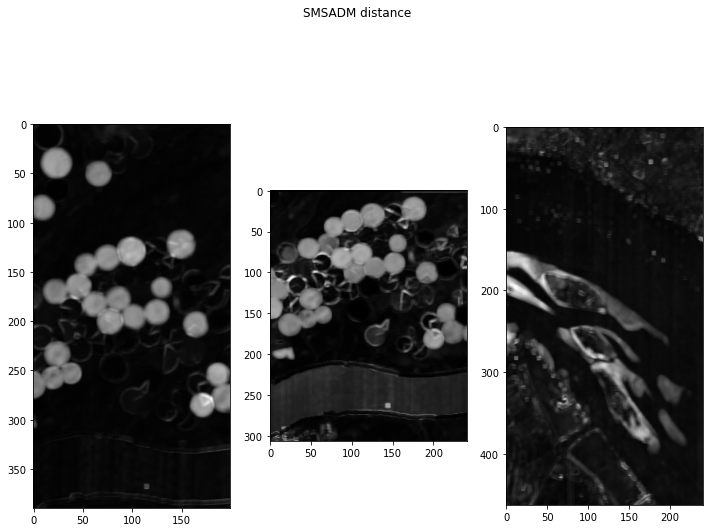

In [30]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,9))
fig.suptitle('SMSADM distance')
ax1.imshow(Hsc.reshape(m1,n1),cmap = plt.cm.gray)
ax2.imshow(Usc.reshape(mu1,nu1), cmap = plt.cm.gray)
ax3.imshow(Rsc.reshape(mr1,nr1), cmap = plt.cm.gray)

In [31]:
Hsc = Scale(Hsc)

Usc = Scale(Usc)

Rsc = Scale(Rsc)

In [32]:
MediaHsc = Binarize1(Hsc)
MediaHsc[MediaHsc>=1.0]=1.0
MediaHsc[MediaHsc<1.0]=0.0
MediaHsc = MediaHsc.astype(int)

MediaUsc =  Binarize1(Usc)
MediaUsc[MediaUsc>=1.0]=1.0
MediaUsc[MediaUsc<1.0]=0.0
MediaUsc = MediaUsc.astype(int)


MediaRsc =  Binarize1(Rsc)
MediaRsc[MediaRsc>=1.0]=1.0
MediaRsc[MediaRsc<1.0]=0.0
MediaRsc = MediaRsc.astype(int)

# $\|\cdot\|_1$

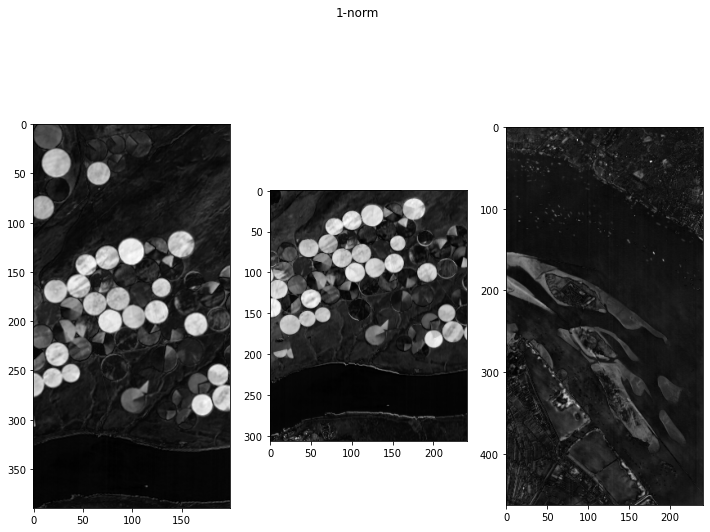

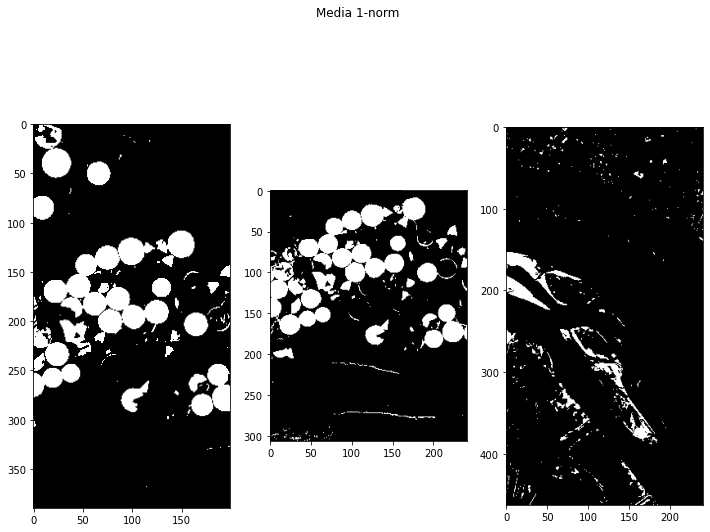

In [34]:
H1norm = np.zeros(m1*n1)
U1norm = np.zeros(mu1*nu1)
R1norm = np.zeros(mr1*nr1)

for i in range(m1*n1):
    H1norm[i]= np.sum(abs(H1[i,:]-H2[i,:]))
for i in range(mu1*nu1):
    U1norm[i]= np.sum(abs(U1[i,:]-U2[i,:]))
for i in range(mr1*nr1):
    R1norm[i]= np.sum(abs(R1[i,:]-R2[i,:]))

 
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,9))
fig.suptitle('1-norm')
ax1.imshow(H1norm.reshape(m1,n1),cmap = plt.cm.gray)
ax2.imshow(U1norm.reshape(mu1,nu1), cmap = plt.cm.gray)
ax3.imshow(R1norm.reshape(mr1,nr1), cmap = plt.cm.gray)


H1norm = Scale(H1norm)
U1norm = Scale(U1norm)
R1norm = Scale(R1norm)


MediaH1norm = Binarize1(H1norm)
MediaH1norm[MediaH1norm>=1.0]=1.0
MediaH1norm[MediaH1norm<1.0]=0.0
MediaH1norm = MediaH1norm.astype(int)


MediaU1norm =  Binarize1(U1norm)
MediaU1norm[MediaU1norm>=1.0]=1.0
MediaU1norm[MediaU1norm<1.0]=0.0
MediaU1norm = MediaU1norm.astype(int)


MediaR1norm =  Binarize1(R1norm)
MediaR1norm[MediaR1norm>=1.0]=1.0
MediaR1norm[MediaR1norm<1.0]=0.0
MediaR1norm = MediaR1norm.astype(int)

#####

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,9))
fig.suptitle('Media 1-norm')
ax1.imshow(MediaH1norm.reshape(m1,n1),cmap = plt.cm.gray)
ax2.imshow(MediaU1norm.reshape(mu1,nu1), cmap = plt.cm.gray)
ax3.imshow(MediaR1norm.reshape(mr1,nr1), cmap = plt.cm.gray)

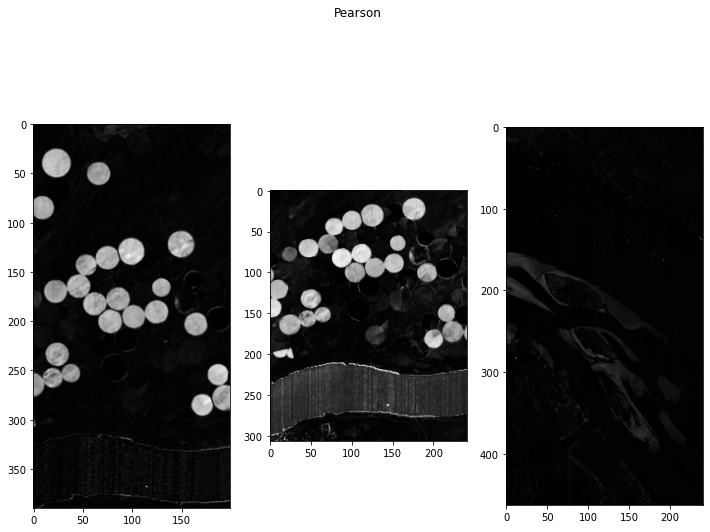

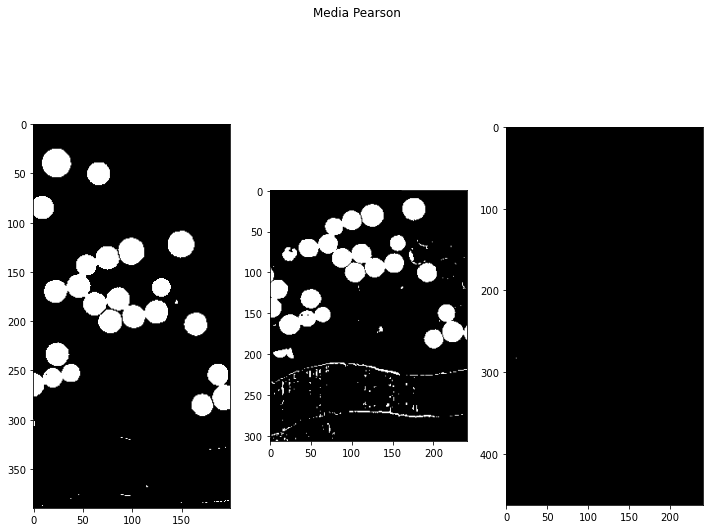

In [36]:
Hpr = np.zeros(m1*n1)
Upr = np.zeros(mu1*nu1)
Rpr = np.zeros(mr1*nr1)

for i in range(m1*n1):
    Hpr[i],sH = stats.pearsonr((H1[i,:]),(H2[i,:]))
for i in range(mu1*nu1):
    Upr[i],sU = stats.pearsonr((U1[i,:]),(U2[i,:]))
for i in range(mr1*nr1):
    Rpr[i],sR = stats.pearsonr((R1[i,:]),(R2[i,:]))

    
Hpr = 1-abs(Hpr)
Upr = 1-abs(Upr)
Rpr = 1-abs(Rpr)


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,9))
fig.suptitle('Pearson')
ax1.imshow(Hpr.reshape(m1,n1),cmap = plt.cm.gray)
ax2.imshow(Upr.reshape(mu1,nu1), cmap = plt.cm.gray)
ax3.imshow(Rpr.reshape(mr1,nr1), cmap = plt.cm.gray)


Hpr = Scale(Hpr)
Upr = Scale(Upr)
Rpr = Scale(Rpr)


MediaHpr = Binarize1(Hpr)
MediaHpr[MediaHpr>=1.0]=1.0
MediaHpr[MediaHpr<1.0]=0.0
MediaHpr = MediaHpr.astype(int)


MediaUpr =  Binarize1(Upr)
MediaUpr[MediaUpr>=1.0]=1.0
MediaUpr[MediaUpr<1.0]=0.0
MediaUpr = MediaUpr.astype(int)


MediaRpr =  Binarize1(Rpr)
MediaRpr[MediaRpr>=1.0]=1.0
MediaRpr[MediaRpr<1.0]=0.0
MediaRpr = MediaRpr.astype(int)

#####

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,9))
fig.suptitle('Media Pearson')
ax1.imshow(MediaHpr.reshape(m1,n1),cmap = plt.cm.gray)
ax2.imshow(MediaUpr.reshape(mu1,nu1), cmap = plt.cm.gray)
ax3.imshow(MediaRpr.reshape(mr1,nr1), cmap = plt.cm.gray)

In [37]:
OUT_H = (MediaEuH.reshape(m1,n1)+MediaHsc+MediaHsM+MediaHpr.reshape(m1,n1)+MediaH1norm.reshape(m1,n1)+MediaHssz.reshape(m1,n1))#
OUT_U = (MediaEuU.reshape(mu1,nu1) +MediaUsM+MediaUsc+MediaUpr.reshape(mu1,nu1)+MediaU1norm.reshape(mu1,nu1)+MediaUssz.reshape(mu1,nu1))#
OUT_R = (MediaEuR.reshape(mr1,nr1) +MediaRsc+MediaRsM+MediaRpr.reshape(mr1,nr1)+MediaR1norm.reshape(mr1,nr1)+MediaRssz.reshape(mr1,nr1))#

In [38]:
nOUT_H = np.copy(OUT_H)
nOUT_H[nOUT_H<3]=0
nOUT_H[nOUT_H>=3]=1


nOUT_U = np.copy(OUT_U)
nOUT_U[nOUT_U<3]=0
nOUT_U[nOUT_U>=3]=1


nOUT_R = np.copy(OUT_R)
nOUT_R[nOUT_R<3]=0
nOUT_R[nOUT_R>=3]=1

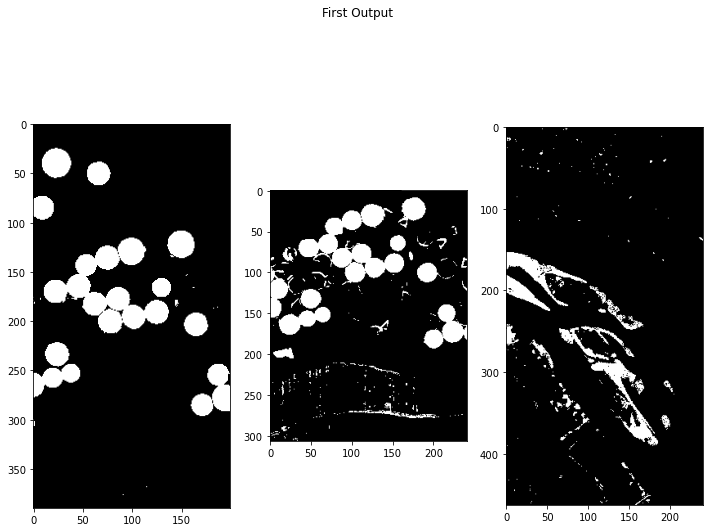

In [39]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,9))
fig.suptitle('First Output')
ax1.imshow(nOUT_H.reshape(m1,n1),cmap = plt.cm.gray)
ax2.imshow(nOUT_U.reshape(mu1,nu1), cmap = plt.cm.gray)
ax3.imshow(nOUT_R.reshape(mr1,nr1), cmap = plt.cm.gray)

In [40]:
cnfH =confusion_matrix(new_gt, nOUT_H.ravel()).ravel()
OAH,KH = OA_K(cnfH)
print('\n overall accuracy Hermiston  ', OAH)
print('\n Kappa coeff Hermiston  ', KH)


cnfU =confusion_matrix(gtU.ravel(), nOUT_U.ravel()).ravel()
OAU,KU = OA_K(cnfU)
print('\n overall accuracy USA  ', OAU)
print('\n Kappa coeff USA  ', KU)


cnfR =confusion_matrix(gtR.ravel(), nOUT_R.ravel()).ravel()
OAR,KR = OA_K(cnfR)
print('\n overall accuracy River  ', OAR)
print('\n Kappa coeff River  ', KR)



 overall accuracy Hermiston   0.9866794871794872

 Kappa coeff Hermiston   0.9410218110311578

 overall accuracy USA   0.9108221714625543

 Kappa coeff USA   0.7164311235731688

 overall accuracy River   0.9624405151322334

 Kappa coeff River   0.7250442980210057


# Post-Processing Step: 

- For 'Usa' and 'River' dataset, the obtained results can be improved by using the current output 
  as pseudo-labels to a supervised binary classifier

- For 'Hermiston' dataset, since the produced output is a very neat binary map, it is convenient 
  to adopt a pixel-wise cleaning/noise-removal method.

Difference images:

In [41]:
imgU = abs(U1-U2)
imgR = abs(R1-R2)

1st iteration Gaussian NB

In [42]:
clfU = GaussianNB()
outUF = clfU.fit(imgU, nOUT_U.reshape(mu1*nu1)).predict(imgU)

clfR = GaussianNB()
outRF = clfR.fit(imgR, nOUT_R.reshape(mr1*nr1)).predict(imgR)


cnfU =confusion_matrix(gtU.ravel(), outUF).ravel()
OAU,KU = OA_K(cnfU)
print('\n overall accuracy USA  ', OAU)
print('\n Kappa coeff USA  ', KU)


cnfR =confusion_matrix(gtR.ravel(), outRF).ravel()
OAR,KR = OA_K(cnfR)
print('\n overall accuracy River  ', OAR)
print('\n Kappa coeff River  ', KR)



 overall accuracy USA   0.9451390109073216

 Kappa coeff USA   0.8341752117302464

 overall accuracy River   0.9609438713782565

 Kappa coeff River   0.7711179927663249


2nd iteration of Gaussian Nb

In [43]:
clfU = GaussianNB(var_smoothing=.11252e-2)#
outUF = clfU.fit(imgU, outUF.reshape(mu1*nu1)).predict(imgU)
clfR = GaussianNB(var_smoothing=1.0)
outRF = clfR.fit(imgR, outRF.reshape(mr1*nr1)).predict(imgR)


cnfU =confusion_matrix(gtU.ravel(), outUF).ravel()
OAU,KU = OA_K(cnfU)
print('\n overall accuracy USA  ', OAU)
print('\n Kappa coeff USA  ', KU)


cnfR =confusion_matrix(gtR.ravel(), outRF).ravel()
OAR,KR = OA_K(cnfR)
print('\n overall accuracy River  ', OAR)
print('\n Kappa coeff River  ', KR)


 overall accuracy USA   0.9528025193615095

 Kappa coeff USA   0.8630043054922464

 overall accuracy River   0.9681223842341575

 Kappa coeff River   0.8013886129992429


For the Hermiston dataset instead it is convenient to remove the noise by adopting a pixel wise "filter". For such aim, a morphological opening transformation is chosen.

In [44]:
def clean_map1(change_map):
    change_map = change_map.astype(np.uint8)
    kernel1     = np.asarray((( 0,0,1,0,0),
                               (0,1,1,1,0),
                               (1,1,1,1,1),
                               (0,1,1,1,0),
                               (0,0,1,0,0)), dtype=np.uint8)
 
    cleanChangeMap = cv2.morphologyEx(change_map, cv2.MORPH_OPEN, kernel1)

    return cleanChangeMap

In [45]:
CleanedH = clean_map1(nOUT_H.reshape(m1,n1))

In [46]:
cnfH =confusion_matrix(new_gt, CleanedH.ravel()).ravel()
OAH,KH = OA_K(cnfH)
print('\n overall accuracy Hermiston  ', OAH)
print('\n Kappa coeff Hermiston  ', KH)


 overall accuracy Hermiston   0.9875512820512821

 Kappa coeff Hermiston   0.9446715027943061


Text(0.5, 1.0, 'Final Output')

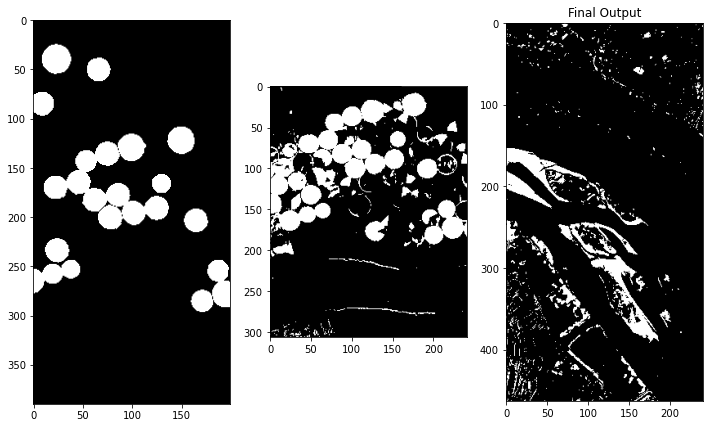

In [47]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(12,9))
ax1.imshow(CleanedH.reshape(m1,n1),cmap = plt.cm.gray)
ax2.imshow(outUF.reshape(mu1,nu1), cmap = plt.cm.gray)
ax3.imshow(outRF.reshape(mr1,nr1), cmap = plt.cm.gray)
plt.title('Final Output')
